# Aspect Identifying
###### 7/6 - Assigment 4
<p> We take the tweets out of the data, clean them of html, hashtags and mentions, then run the text through a tokenizer before identifying the most common words/phrases throughout the tweets. Those common words/phrases are then the aspects we base the clustering of the tweets on. As of right now, the model is using singular terms with a fixed dictionary, the hope is to move towards a dynamic dictionary that grows with the new data recieved.</p>

###### 7/12 - Assigment 5
<p>We are now showing the top 10 words per cluster and doing postprocessing on those words for cluster assignment. Instead of trying to assign one cluster at first, each tweet has been given a cluster ranking, indicating how much of a cluster each one is assigned to. Also, we have added in clustering by k-means to determine the amount of clusters there should be through a scientific and data-driven approach, rather than 5 for convenience.</p>

7/19 - Assignment 6

In [1]:
import preprocessor as p #https://pypi.org/project/tweet-preprocessor/
import numpy as np
import pandas as pd
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import string
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

Read the tweets

In [2]:
df = pd.read_csv('data/Tweets.csv')
tweets = df.text
reasons = df.negativereason

In [3]:
reasons

0                           NaN
1                           NaN
2                           NaN
3                    Bad Flight
4                    Can't Tell
                  ...          
14635                       NaN
14636    Customer Service Issue
14637                       NaN
14638    Customer Service Issue
14639                       NaN
Name: negativereason, Length: 14640, dtype: object

In [4]:
df.negativereason.value_counts(dropna=False)

NaN                            5462
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [5]:
new_tweets = []
for tweet in tweets:
    tweet = tweet.lower()
    tweet = BeautifulSoup(tweet, 'html.parser').getText()
    tweet = p.clean(tweet)
    new_tweets.append(tweet)

In [6]:
tweets = new_tweets
#tweets

In [7]:
stopwords = nltk.corpus.stopwords.words('english')

stemmer = SnowballStemmer("english")

In [8]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [9]:
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    return filtered_tokens

In [10]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in tweets:
    allwords_stemmed = tokenize_and_stem(i) # for each item in 'tweets', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [11]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [12]:
#https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=100,
                                   stop_words='english', max_features=10000,
                                   strip_accents='unicode', use_idf=True, 
                                   tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets) #fit the vectorizer to tweets

C:\Code\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 8.95 s


In [14]:
terms = tfidf_vectorizer.get_feature_names()
#print(terms)
tfidf_vectorizer.fit(tweets)
%time text = tfidf_vectorizer.transform(tweets)
#print(text)

C:\Code\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Wall time: 8.83 s


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters


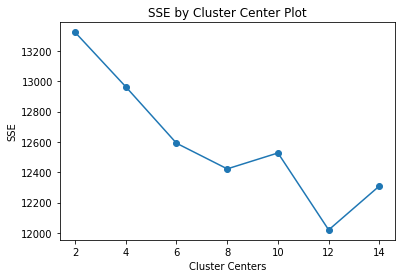

In [15]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 15)

In [16]:
cluster_amt = 8

In [17]:
clusters = MiniBatchKMeans(n_clusters=cluster_amt, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

In [18]:
from sklearn.cluster import KMeans

num_clusters = cluster_amt

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 8.25 s


In [19]:
Tweets = {'tweet': tweets, 'cluster': clusters}

#frame = pd.DataFrame(Tweets, clusters)
frame = pd.DataFrame(Tweets)
frame['Aspect'] = "Miscellaneous"

#print(frame)

frame['cluster'].value_counts() #number of tweets per cluster (clusters from 0 to 5)


3    6943
7    2064
5    1431
0     997
4     908
6     907
2     746
1     644
Name: cluster, dtype: int64

In [20]:
aspectsDF = pd.DataFrame(columns = ['Word', "Reason"])

In [21]:
print("Top terms per cluster:")

#https://7esl.com/contractions-list/
contractions = ["n't","'s","'m","'ll","'d","'ve","'re"]
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(cluster_amt):
    print("Cluster %d words:" % i, end='')
    name = "Cluster %d words:" % i
    
    for ind in order_centroids[i, :20]:
        word = ' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0]
        word = word.replace(" ", "")
        if word not in aspectsDF.values and word not in contractions:
            print(word, end=',')
            aspectsDF.loc[len(aspectsDF.index)] = [word, "Miscellaneous"]
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:
Cluster 0 words:hour,hold,fleek,fleet,delayed,waited,flight,plane,sit,bag,time,late,just,got,gate,minutes,

Cluster 1 words:customer,service,worst,thanks,terrible,today,phone,great,airline,help,agent,line,experience,

Cluster 2 words:please,need,trying,change,reserved,ticket,appreciate,booking,very,

Cluster 3 words:flying,like,days,seats,love,check,guys,why,making,

Cluster 4 words:response,good,awesome,sent,follow,hope,care,did,yes,

Cluster 5 words:does,working,know,because,

Cluster 6 words:cancelled,flightled,rebook,tomorrow,dfw,

Cluster 7 words:attendant,missed,connecting,any,boarding,



In [22]:
aspect_assignments = {'Customer Service':['contact', 'emailed', 'fix', 'staff', 'speak', 'talk', 'care', 'experience', 'rep', 'issue', 'thanks', 'hold', 'thank', 'appreciate', 'response', 'service', 'customer', 'phone', 'agent', 'email', 'speak', 'help', 'please', 'call', 'refund', 'need'],
                      'Ongoing Flight(s)':['travel', 'wifi', 'leaving', 'updates', 'weather', 'attendant', 'connecting', 'early', 'arrived', 'landed', 'gate', 'delay', 'delayed', 'late', 'status', 'schedule', 'cancelled', 'cancel', 'pilots', 'pilot', 'passengers', 'passenger', 'boarding'],
                      'Booking': ['pass', 'credit', 'miles', 'hotel', 'app', 'fee', 'voucher', 'upgrade', 'class', 'available', 'website', 'online', 'book', 'booking', 'seats', 'seat', 'boarding', 'rebook', 'confirmation', 'reschedule', 'ticket', 'reserved'],
                      'Luggage': ['bag', 'check', 'lost', 'baggage', 'bags', 'luggage', 'claim'],
                      'Wait Times': ['wait', 'waited', 'stuck', 'line', 'hour', 'hours', 'minutes', 'days', 'today', 'tomorrow', 'time', 'min', 'hrs']
                      }

def get_key(val):
    for key, value in aspect_assignments.items():
        for item in value:
            if (val == item):
                return key

In [31]:
def get_aspect_for_tweet(tweet):
    cs = 0
    of = 0
    bo = 0
    lu = 0
    wt = 0
    me = 0
    tweet_array = tweet.split(" ")
    for word in tweet_array:
        tof = False
        for value in aspect_assignments.values():
            if (word in value):
                tof = True
                aspect = get_key(word)
                if aspect == 'Customer Service':
                    cs += 1
                if aspect == 'Ongoing Flight(s)':
                    of += 1
                if aspect == 'Booking':
                    bo += 1
                if aspect == 'Luggage':
                    lu += 1
                if aspect == 'Wait Times':
                    wt += 1
                break

    assignments = {'cs': cs,'of': of,'bo': bo,'lu': lu,'me': me}
    test_value = max(assignments.values())
    test_key = 'me'
    if test_value > 0:
        for key, value in assignments.items():
            if test_value == value:
                test_key = key
                break
    aspects = {'cs': 'Customer Service', 'of': 'Ongoing Flight(s)', 'bo': 'Booking', 'lu': 'Luggage', 'me': "Miscellaneous"} 
    tweet_index = frame.index[frame['tweet'] == tweet].tolist()[0]
    frame.loc[tweet_index, 'Aspect'] = aspects[test_key]

In [32]:
for tweet in tweets:
    get_aspect_for_tweet(tweet)

In [33]:
df['Aspect'] = frame['Aspect']

In [34]:
df.negativereason.value_counts(dropna=False)

NaN                            5462
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [35]:
(5462+1190)/14640

0.45437158469945355

In [36]:
df.Aspect.value_counts(dropna=False)

Miscellaneous        6057
Customer Service     4710
Ongoing Flight(s)    2251
Booking               982
Luggage               640
Name: Aspect, dtype: int64

In [37]:
6057/14640

0.41372950819672133